In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from ray.rllib.agents.trainer import Trainer, with_common_config
from ray.rllib.utils.annotations import override


/home/rajanr/anaconda3/envs/py36_toy_rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rajanr/anaconda3/envs/py36_toy_rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rajanr/anaconda3/envs/py36_toy_rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rajanr/anaconda3/envs/py3

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
# yapf: disable
# __sphinx_doc_begin__
class RandomAgent(Trainer):
    """Policy that takes random actions and never learns."""

    _name = "RandomAgent"
    _default_config = with_common_config({
        "rollouts_per_iteration": 10,
    })

    @override(Trainer)
    def _init(self, config, env_creator):
        self.env = env_creator(config["env_config"])

    @override(Trainer)
    def _train(self):
        rewards = []
        steps = 0
        for _ in range(self.config["rollouts_per_iteration"]):
            obs = self.env.reset()
            done = False
            reward = 0.0
            while not done:
                action = self.env.action_space.sample()
                obs, r, done, info = self.env.step(action)

                reward += r
                steps += 1
            rewards.append(reward)
        return {
            "episode_reward_mean": np.mean(rewards),
            "timesteps_this_iter": steps,
        }

class VIAgent(Trainer):
    """Value Iteration.
    #TODO Make it Generalized PI.
    """

    _name = "VIAgent"
    _default_config = with_common_config({
        "tolerance": 0.01,
        "discount_factor": 0.5,
        "rollouts_per_iteration": 10,
        "episode_length": 200,
        # "lr": 0.5
    })

    @override(Trainer)
    def _init(self, config, env_creator):
        self.env = env_creator(config["env_config"])
        self.V = np.zeros(self.env.observation_space.n)
        self.policy = np.zeros(self.env.observation_space.n, dtype=int)
        self.policy[:] = -1 #IMP # To avoid initing it to a value within action_space range

    @override(Trainer)
    def _train(self):
        max_diff = np.inf # Maybe keep a state variable so that we don't need to update every train iteration??
        state_space_size = self.env.observation_space.n
        gamma = self.config["discount_factor"]
        total_iterations = 0
        while max_diff > self.config["tolerance"]:
            total_iterations += 1
            for s in range(state_space_size):
                # print("self.V[:]", s, max_diff, self.V, [self.env.R(s, a) for a in range(self.env.action_space.n)], self.policy[s])
                self.V_old = self.V.copy() # Is this asynchronous? V_old should be held constant for all states in the for loop?
                # print([self.env.R(s, a) for a in range(self.env.action_space.n)], [gamma * self.V[self.env.P(s, a)] for a in range(self.env.action_space.n)], [self.env.R(s, a) + gamma * self.V[self.env.P(s, a)] for a in range(self.env.action_space.n)])
                self.policy[s] = np.argmax([self.env.R(s, a) + gamma * self.V[self.env.P(s, a)] for a in range(self.env.action_space.n)])
                self.V[s] = np.max([self.env.R(s, a) + gamma * self.V[self.env.P(s, a)] for a in range(self.env.action_space.n)]) # We want R to be a callable function, so I guess we have to keep a for loop here??
                # print("self.V, self.V_old, self.policy[s]", self.V, self.V_old, self.policy[s], self.env.P(s, self.policy[s]))

                max_diff = np.max(np.absolute(self.V_old - self.V))
        # import time
        # time.sleep(2)
#         for s in range(state_space_size):
#             print("FINAL self.V[:]", s, max_diff, self.V[:], [self.env.R(s, a) for a in range(self.env.action_space.n)])

        print("Total iterations:", total_iterations)
        rewards = []
        steps = 0
        for _ in range(self.config["rollouts_per_iteration"]):
            obs = self.env.reset()
            done = False
            reward = 0.0
            for _ in range(self.config["episode_length"]):
                action = self.policy[obs]
                obs, r, done, info = self.env.step(action)

                reward += r
                steps += 1
            rewards.append(reward)
        return {
            "episode_reward_mean": np.mean(rewards),
            "timesteps_this_iter": steps,
        }


In [ ]:
import ray
from ray import tune
from ray.rllib.utils.seed import seed as rllib_seed
import rl_toy
from rl_toy.envs import RLToyEnv
from ray.tune.registry import register_env
register_env("RLToy-v0", lambda config: RLToyEnv(config))

# rllib_seed(0, 0, 0)
ray.init()


In [24]:
state_space_sizes = [8, 10, 12, 14] # [2**i for i in range(1,6)]
action_space_sizes = [2, 4, 8, 16] # [2**i for i in range(1,6)]
delays = [0] + [2**i for i in range(5)]
sequence_lengths = [i for i in range(1,6)]
reward_densities = [0.25] # np.linspace(0.0, 1.0, num=5)
# make_reward_dense = [True, False]
terminal_state_densities = [0.25] # np.linspace(0.1, 1.0, num=5)
algorithms = ["DQN"]

print('# Algorithm, state_space_size, action_space_size, delay, sequence_length, reward_density,'
               'terminal_state_density ')
print(algorithms, state_space_sizes, action_space_sizes, delays, sequence_lengths, reward_densities,
      terminal_state_densities)


['DQN'] [8, 10, 12, 14] [2, 4, 8, 16] [0, 1, 2, 4, 8, 16] [1, 2, 3, 4, 5] [0.25] [0.25]
# Algorithm, state_space_size, action_space_size, delay, sequence_length, reward_density,terminal_state_density 


In [ ]:
# stats = {}
# aaaa = 3

#TODO Write addnl. line at beginning of file for column names
# fout = open('rl_stats_temp.csv', 'a') #hardcoded
# fout.write('# basename, n_points, n_features, n_trees ')

import time
start = time.time()
print(algorithms, state_space_sizes, action_space_sizes, delays, 
      sequence_lengths, reward_densities, terminal_state_densities)


def on_train_result(info):
#     print("#############trainer.train() result: {} -> {} episodes".format(
#         info["trainer"], info["result"]["episodes_this_iter"]), info)
    # you can mutate the result dict to add new fields to return
#     stats['episode_len_mean'] = info['result']['episode_len_mean']
#     print("++++++++", aaaa, stats)
    algorithm = info["trainer"]._name
    state_space_size = info["result"]["config"]["env_config"]["state_space_size"]
    action_space_size = info["result"]["config"]["env_config"]["action_space_size"]
    delay = info["result"]["config"]["env_config"]["delay"]
    sequence_length = info["result"]["config"]["env_config"]["sequence_length"]
    reward_density = info["result"]["config"]["env_config"]["reward_density"]
    terminal_state_density = info["result"]["config"]["env_config"]["terminal_state_density"]

    timesteps_total = info["result"]["timesteps_total"] # also has episodes_total and training_iteration
    episode_reward_mean = info["result"]["episode_reward_mean"] # also has max and min
    episode_len_mean = info["result"]["episode_len_mean"]
    
    fout = open('/home/rajanr/custom-gym-env/rl_stats_temp.csv', 'a') #hardcoded
    fout.write('# Algorithm, state_space_size, action_space_size, delay, sequence_length, reward_density, '
               'terminal_state_density,\n' + str(algorithm) + ' ' + str(state_space_size) + 
               ' ' + str(action_space_size) + ' ' + str(delay) + ' ' + str(sequence_length) 
               + ' ' + str(reward_density) + ' ' + str(terminal_state_density) + ' ')
               # Writes every iteration, would slow things down. #hack
    fout.write(str(timesteps_total) + ' ' + str(episode_reward_mean) + 
               ' ' + str(episode_len_mean) + '\n')
    fout.close()

    info["result"]["callback_ok"] = True
    


# tune.run(
#     RandomAgent,
#     stop={
#         "timesteps_total": 20000,
#           },
#     config={
#       "rollouts_per_iteration": 10,
#       "env": "RLToy-v0",
#       "env_config": {
#         'state_space_type': 'discrete',
#         'action_space_type': 'discrete',
#         'state_space_size': 16,
#         'action_space_size': 16,
#         'generate_random_mdp': True,
#         'delay': 6,
#         'sequence_length': 1,
#         'reward_density': 0.25,
#         'terminal_state_density': 0.25
#         },
#     },
# )

# tune.run(
#     VIAgent,
#     stop={
#         "timesteps_total": 20000,
#           },
#     config={
#         "tolerance": 0.01,
#         "discount_factor": 0.99,
#         "rollouts_per_iteration": 10,
#       "env": "RLToy-v0",
#       "env_config": {
#         'state_space_type': 'discrete',
#         'action_space_type': 'discrete',
#         'state_space_size': 10,
#         'action_space_size': 10,
#         'generate_random_mdp': True,
#         'delay': 0,
#         'sequence_length': 1,
#         'reward_density': 0.25,
#         'terminal_state_density': 0.25
#         },
#     },
# )

for algorithm in algorithms: #TODO each one has different config_spaces
    for state_space_size in state_space_sizes:
        for action_space_size in action_space_sizes:
            for delay in delays:
                for sequence_length in sequence_lengths:
                    for reward_density in reward_densities:
                        for terminal_state_density in terminal_state_densities:

                            tune.run(
                                algorithm,
                                stop={
                                    "timesteps_total": 20000,
                                      },
                                config={
                                  "adam_epsilon": 0.00015,
                                  "beta_annealing_fraction": 1.0,
                                  "buffer_size": 1000000,
                                  "double_q": False,
                                  "dueling": False,
                                  "env": "RLToy-v0",
                                  "env_config": {
                                    'state_space_type': 'discrete',
                                    'action_space_type': 'discrete',
                                    'state_space_size': state_space_size,
                                    'action_space_size': action_space_size,
                                    'generate_random_mdp': True,
                                    'delay': delay,
                                    'sequence_length': sequence_length,
                                    'reward_density': reward_density,
                                    'terminal_state_density': terminal_state_density
                                    },
                                  "exploration_final_eps": 0.01,
                                  "exploration_fraction": 0.1,
                                  "final_prioritized_replay_beta": 1.0,
                                  "hiddens": [
                                    256
                                  ],
                                  "learning_starts": 2000,
                                  "lr": 6.25e-05, # "lr": grid_search([1e-2, 1e-4, 1e-6]),
                                  "n_step": 1,
                                  "noisy": False,
                                  "num_atoms": 1,
                                  "prioritized_replay": False,
                                  "prioritized_replay_alpha": 0.5,
                                  "sample_batch_size": 4,
                                  "schedule_max_timesteps": 20000,
                                  "target_network_update_freq": 80,
                                  "timesteps_per_iteration": 100,
                                  "train_batch_size": 32,

                                          "callbacks": {
                            #                 "on_episode_start": tune.function(on_episode_start),
                            #                 "on_episode_step": tune.function(on_episode_step),
                            #                 "on_episode_end": tune.function(on_episode_end),
                            #                 "on_sample_end": tune.function(on_sample_end),
                                            "on_train_result": tune.function(on_train_result),
                            #                 "on_postprocess_traj": tune.function(on_postprocess_traj),
                                        },
                                },
                            )

end = time.time()
print("No. of seconds to run:", end - start)

In [ ]:
# average over 5-10 runs
# Keep minimum state size of 5 - so 1 terminal, 4 possible sequences of length 1 and 1 of them is rewarded - actually depends on densities
# min action size of 2; max action size up to twice of state space size; 
# delay looks ok
# sequence_lengths up to 6?

# Hyperparam search over RL algo. hyperparams, optimizer hyperparams; only for max sequence length and min delay?
# Hyperparams:



In [ ]:
# stats
# fout = open('rl_stats_temp.csv', 'a') #hardcoded
# fout.write('# basename, n_points, n_features, n_trees ')

# fout.close()

In [18]:
##NOT USED - Getting too complicated and error-prone
# import numpy as np
dir_name = '/home/rajanr/custom-gym-env' #run
stats_file = dir_name + '/' + 'rl_stats_temp2.csv' #Name of file to which benchmark stats were written

datasets_info = np.loadtxt(stats_file)
# print(datasets_info)
# print(type(datasets_info))
# print(datasets_info.shape)

# Slice up the n_features=all features values for every dataset
num_values_per_hyperparam = (1, 5, 5, 6, 5, 1, 1)
hyperparam_string = '# Algorithm, state_space_size, action_space_size, delay, sequence_length, reward_density, terminal_state_density, '
print(hyperparam_string.split())

hyperparams = hyperparam_string.split()[1:]
hyperparams_list = []
hyperparams_list2 = []
for hyperparam in hyperparams:
    hyperparams_list.append([])
    hyperparams_list2.append([])

print(hyperparams_list)
    
alg_names = np.empty(0, dtype=np.unicode_)#
state_space_sizes = np.empty(0, dtype=np.int64)#np.unicode_
action_space_sizes = np.empty(0, dtype=np.int64)
delays = np.empty(0, dtype=np.int64)
sequence_lengths = np.empty(0, dtype=np.int64)
reward_densities = np.empty(0, dtype=np.float64)
terminal_state_densities = np.empty(0, dtype=np.float64)

prev_total_timesteps = 0

for line in open(stats_file):
    line=line.strip()
    if line.startswith("#"):
        comment = line.split(' ')
        for i in range(len(hyperparams)):
            if comment[len(hyperparams) + i + 1] not in hyperparams_list[i]:
                #TODO Take datatype into account
                hyperparams_list[i].append(comment[len(hyperparams) + i + 1])
        # Can remove following code:
        if comment[8] not in alg_names:
            alg_names = np.append(alg_names, comment[8])
        if np.int64(comment[9]) not in state_space_sizes:
            state_space_sizes = np.append(state_space_sizes, np.int64(comment[9]))
        if np.int64(comment[10]) not in action_space_sizes:
            action_space_sizes = np.append(action_space_sizes, np.int64(comment[10]))
        if np.int64(comment[11]) not in delays:
            delays = np.append(delays, np.int64(comment[11]))
        if np.int64(comment[12]) not in sequence_lengths:
            sequence_lengths = np.append(sequence_lengths, np.int64(comment[12]))
        if np.float64(comment[13]) not in reward_densities:
            reward_densities = np.append(reward_densities, np.float64(comment[13]))
        if np.float64(comment[14]) not in terminal_state_densities:
            terminal_state_densities = np.append(terminal_state_densities, np.float64(comment[14]))

#TODO define hyperparams_list manually here - remove previous for reading stats_file; and also columns of metrics at the top of CSV file!
print(hyperparams_list)
shape_ = [len(hyperparams_list[i]) for i in range(len(hyperparams_list))]
shape_2 = [len(hyperparams_list[i]) for i in range(len(hyperparams_list))] + [3] #hack
# shape_tuple = tuple

# Allocate array in advance based on 1st reading of file (Should be more efficient to allocate at once)
values_ = np.empty(shape = shape_, dtype=object) # object because each cell's contents could be variably shaped
print(values_.shape)
values_2 = np.empty(shape = shape_2, dtype=np.float64) # object because each cell's contents could be variably shaped
print(values_2.shape)


for line in open(stats_file):
    line=line.strip()
#    print(line)
    if line.startswith("#"):
        comment = line.split(' ')
        for i in range(len(hyperparams)):
            if comment[len(hyperparams) + i + 1] not in hyperparams_list2[i]:
                #TODO Take datatype into account
                hyperparams_list2[i].append(comment[len(hyperparams) + i + 1])
#         print(hyperparams_list2)
        # Calculate the index of the "most newly created cell" just now
                index_ = [len(hyperparams_list2[i]) - 1 for i in range(len(hyperparams_list2))]
        #         print(index_, values_.shape)
        #         print(values_[index_])
                values_[tuple(index_)] = np.empty(shape=(0, 3), dtype=object)
    else:
        comment_vals = line.split(' ')
        total_timesteps = np.int64(comment_vals[0])
        episode_reward_mean = np.float64(comment_vals[1])
        episode_len_mean = np.float64(comment_vals[2])
        vals_list = [total_timesteps, episode_reward_mean, episode_len_mean]
        index_ = [len(hyperparams_list2[i]) - 1 for i in range(len(hyperparams_list2))]
        values_[tuple(index_)] = np.vstack([values_[tuple(index_)], np.array(vals_list)])
        values_2[tuple(index_)] = np.array(vals_list)
        print(values_2[tuple(index_)], index_)
#         metrics_list[alg_names[-1]].append(comment_vals)

print(hyperparams_list2)
print(values_2)

#
#for i
print(alg_names)
print(state_space_sizes)
print(action_space_sizes)
print(delays)
print(sequence_lengths)
print(reward_densities)
print(terminal_state_densities)



['#', 'Algorithm,', 'state_space_size,', 'action_space_size,', 'delay,', 'sequence_length,', 'reward_density,', 'terminal_state_density,']
[[], [], [], [], [], [], []]
[['DQN'], ['2', '4', '8', '16'], ['2', '4', '8', '16', '32'], ['0', '1', '2', '4', '8', '16'], ['1', '2', '3', '4', '5'], ['0.25'], ['0.25']]
(1, 4, 5, 6, 5, 1, 1)
(1, 4, 5, 6, 5, 1, 1, 3)
[1012.   nan   nan] [0, 0, 0, 0, 0, 0, 0]
[2004.   nan   nan] [0, 0, 0, 0, 0, 0, 0]
[2492.   nan   nan] [0, 0, 0, 0, 0, 0, 0]
[2980.   nan   nan] [0, 0, 0, 0, 0, 0, 0]
[3464.   nan   nan] [0, 0, 0, 0, 0, 0, 0]
[3916.   nan   nan] [0, 0, 0, 0, 0, 0, 0]
[4268.   nan   nan] [0, 0, 0, 0, 0, 0, 0]
[4684.   nan   nan] [0, 0, 0, 0, 0, 0, 0]
[5184.   nan   nan] [0, 0, 0, 0, 0, 0, 0]
[5680.   nan   nan] [0, 0, 0, 0, 0, 0, 0]
[6148.   nan   nan] [0, 0, 0, 0, 0, 0, 0]
[6612.   nan   nan] [0, 0, 0, 0, 0, 0, 0]
[7104.   nan   nan] [0, 0, 0, 0, 0, 0, 0]
[7552.   nan   nan] [0, 0, 0, 0, 0, 0, 0]
[7944.   nan   nan] [0, 0, 0, 0, 0, 0, 0]
[8284.   nan 

[3724.      0.     15.22] [0, 0, 0, 3, 4, 0, 0]
[4204.      0.     22.07] [0, 0, 0, 3, 4, 0, 0]
[4684.      0.     23.02] [0, 0, 0, 3, 4, 0, 0]
[5168.      0.     30.92] [0, 0, 0, 3, 4, 0, 0]
[5600.      0.     34.81] [0, 0, 0, 3, 4, 0, 0]
[6036.      0.     38.75] [0, 0, 0, 3, 4, 0, 0]
[6512.      0.     44.56] [0, 0, 0, 3, 4, 0, 0]
[6972.      0.     48.53] [0, 0, 0, 3, 4, 0, 0]
[7456.      0.     54.86] [0, 0, 0, 3, 4, 0, 0]
[7936.      0.     57.31] [0, 0, 0, 3, 4, 0, 0]
[8420.      0.     61.96] [0, 0, 0, 3, 4, 0, 0]
[8900.      0.     66.63] [0, 0, 0, 3, 4, 0, 0]
[9356.      0.     73.23] [0, 0, 0, 3, 4, 0, 0]
[9732.      0.     75.44] [0, 0, 0, 3, 4, 0, 0]
[10128.       0.      75.44] [0, 0, 0, 3, 4, 0, 0]
[10512.       0.      83.03] [0, 0, 0, 3, 4, 0, 0]
[10936.       0.      89.34] [0, 0, 0, 3, 4, 0, 0]
[11420.       0.      92.65] [0, 0, 0, 3, 4, 0, 0]
[11908.      0.     98.7] [0, 0, 0, 3, 4, 0, 0]
[12388.       0.     103.22] [0, 0, 0, 3, 4, 0, 0]
[12876.       0.     105.

[12684.       0.     106.46] [0, 0, 0, 5, 4, 0, 0]
[13180.       0.     111.01] [0, 0, 0, 5, 4, 0, 0]
[13676.       0.     114.72] [0, 0, 0, 5, 4, 0, 0]
[14168.       0.     121.91] [0, 0, 0, 5, 4, 0, 0]
[14652.      0.    128.2] [0, 0, 0, 5, 4, 0, 0]
[15140.       0.     130.86] [0, 0, 0, 5, 4, 0, 0]
[15640.       0.     137.72] [0, 0, 0, 5, 4, 0, 0]
[16136.       0.     140.45] [0, 0, 0, 5, 4, 0, 0]
[16628.       0.     145.86] [0, 0, 0, 5, 4, 0, 0]
[17128.       0.     149.99] [0, 0, 0, 5, 4, 0, 0]
[17632.       0.     149.99] [0, 0, 0, 5, 4, 0, 0]
[18124.       0.     149.99] [0, 0, 0, 5, 4, 0, 0]
[18620.       0.     165.07] [0, 0, 0, 5, 4, 0, 0]
[19104.       0.     168.59] [0, 0, 0, 5, 4, 0, 0]
[19600.       0.     173.74] [0, 0, 0, 5, 4, 0, 0]
[20092.      0.    176.2] [0, 0, 0, 5, 4, 0, 0]
[928.           0.           3.79918033] [0, 0, 1, 5, 4, 0, 0]
[1900.            0.            7.38167939] [0, 0, 1, 5, 4, 0, 0]
[2396.      0.      6.45] [0, 0, 1, 5, 4, 0, 0]
[2900.      0

[17120.      0.    148.5] [0, 0, 1, 5, 4, 0, 0]
[17592.       0.     154.77] [0, 0, 1, 5, 4, 0, 0]
[18020.       0.     158.42] [0, 0, 1, 5, 4, 0, 0]
[18452.       0.     161.82] [0, 0, 1, 5, 4, 0, 0]
[18936.       0.     165.01] [0, 0, 1, 5, 4, 0, 0]
[19408.       0.     172.11] [0, 0, 1, 5, 4, 0, 0]
[19900.       0.     172.11] [0, 0, 1, 5, 4, 0, 0]
[20384.      0.    180.3] [0, 0, 1, 5, 4, 0, 0]
[744.   0.   1.] [0, 0, 1, 5, 4, 0, 0]
[1.572e+03 0.000e+00 1.000e+00] [0, 0, 1, 5, 4, 0, 0]
[2.18e+03 0.00e+00 1.00e+00] [0, 0, 1, 5, 4, 0, 0]
[2.6e+03 0.0e+00 1.0e+00] [0, 0, 1, 5, 4, 0, 0]
[3.036e+03 0.000e+00 1.000e+00] [0, 0, 1, 5, 4, 0, 0]
[3.472e+03 0.000e+00 1.000e+00] [0, 0, 1, 5, 4, 0, 0]
[3.904e+03 0.000e+00 1.000e+00] [0, 0, 1, 5, 4, 0, 0]
[4.34e+03 0.00e+00 1.00e+00] [0, 0, 1, 5, 4, 0, 0]
[4.776e+03 0.000e+00 1.000e+00] [0, 0, 1, 5, 4, 0, 0]
[5.208e+03 0.000e+00 1.000e+00] [0, 0, 1, 5, 4, 0, 0]
[5.644e+03 0.000e+00 1.000e+00] [0, 0, 1, 5, 4, 0, 0]
[6.072e+03 0.000e+00 1.000e+00]

[4428.      0.     25.21] [0, 0, 1, 5, 4, 0, 0]
[4924.      0.     25.21] [0, 0, 1, 5, 4, 0, 0]
[5420.     0.    38.5] [0, 0, 1, 5, 4, 0, 0]
[5924.      0.     42.95] [0, 0, 1, 5, 4, 0, 0]
[6420.      0.     49.33] [0, 0, 1, 5, 4, 0, 0]
[6896.     0.    55.9] [0, 0, 1, 5, 4, 0, 0]
[7392.      0.     60.58] [0, 0, 1, 5, 4, 0, 0]
[7888.      0.     60.58] [0, 0, 1, 5, 4, 0, 0]
[8384.      0.     60.58] [0, 0, 1, 5, 4, 0, 0]
[8880.      0.     74.25] [0, 0, 1, 5, 4, 0, 0]
[9376.      0.     77.04] [0, 0, 1, 5, 4, 0, 0]
[9876.      0.     83.07] [0, 0, 1, 5, 4, 0, 0]
[10368.       0.      83.07] [0, 0, 1, 5, 4, 0, 0]
[10868.       0.      94.76] [0, 0, 1, 5, 4, 0, 0]
[11356.       0.      94.76] [0, 0, 1, 5, 4, 0, 0]
[11852.       0.     105.27] [0, 0, 1, 5, 4, 0, 0]
[12332.       0.     105.27] [0, 0, 1, 5, 4, 0, 0]
[12824.       0.     114.24] [0, 0, 1, 5, 4, 0, 0]
[13244.       0.     116.14] [0, 0, 1, 5, 4, 0, 0]
[13700.      0.    121.7] [0, 0, 1, 5, 4, 0, 0]
[14180.       0.     125.

[17176.       0.     151.66] [0, 0, 2, 5, 4, 0, 0]
[17680.       0.     156.47] [0, 0, 2, 5, 4, 0, 0]
[18160.       0.     158.94] [0, 0, 2, 5, 4, 0, 0]
[18640.       0.     164.98] [0, 0, 2, 5, 4, 0, 0]
[19124.       0.     168.65] [0, 0, 2, 5, 4, 0, 0]
[19620.       0.     172.96] [0, 0, 2, 5, 4, 0, 0]
[20116.       0.     179.08] [0, 0, 2, 5, 4, 0, 0]
[908.           0.           2.62608696] [0, 0, 2, 5, 4, 0, 0]
[1900.           0.           4.9009901] [0, 0, 2, 5, 4, 0, 0]
[2396.     0.     9.2] [0, 0, 2, 5, 4, 0, 0]
[2880.      0.     14.04] [0, 0, 2, 5, 4, 0, 0]
[3232.      0.     16.67] [0, 0, 2, 5, 4, 0, 0]
[3700.      0.     21.68] [0, 0, 2, 5, 4, 0, 0]
[4176.      0.     21.68] [0, 0, 2, 5, 4, 0, 0]
[4656.      0.     31.59] [0, 0, 2, 5, 4, 0, 0]
[5140.     0.    36.5] [0, 0, 2, 5, 4, 0, 0]
[5608.     0.    36.5] [0, 0, 2, 5, 4, 0, 0]
[6092.      0.     42.85] [0, 0, 2, 5, 4, 0, 0]
[6576.      0.     49.82] [0, 0, 2, 5, 4, 0, 0]
[7048.      0.     54.49] [0, 0, 2, 5, 4, 0, 0

[17388.       0.     149.21] [0, 0, 2, 5, 4, 0, 0]
[17864.       0.     158.35] [0, 0, 2, 5, 4, 0, 0]
[18344.       0.     159.12] [0, 0, 2, 5, 4, 0, 0]
[18836.       0.     165.34] [0, 0, 2, 5, 4, 0, 0]
[19316.      0.    169.6] [0, 0, 2, 5, 4, 0, 0]
[19788.       0.     176.95] [0, 0, 2, 5, 4, 0, 0]
[20276.       0.     179.06] [0, 0, 2, 5, 4, 0, 0]
[968.         0.         2.515625] [0, 0, 2, 5, 4, 0, 0]
[1.92400000e+03 0.00000000e+00 1.49921753e+00] [0, 0, 2, 5, 4, 0, 0]
[2408.      0.      4.65] [0, 0, 2, 5, 4, 0, 0]
[2900.      0.      7.75] [0, 0, 2, 5, 4, 0, 0]
[3388.      0.     10.76] [0, 0, 2, 5, 4, 0, 0]
[3884.      0.     10.76] [0, 0, 2, 5, 4, 0, 0]
[4384.      0.     23.77] [0, 0, 2, 5, 4, 0, 0]
[4880.      0.     26.35] [0, 0, 2, 5, 4, 0, 0]
[5360.     0.    32.4] [0, 0, 2, 5, 4, 0, 0]
[5828.     0.    35.1] [0, 0, 2, 5, 4, 0, 0]
[6324.      0.     42.53] [0, 0, 2, 5, 4, 0, 0]
[6824.      0.     47.77] [0, 0, 2, 5, 4, 0, 0]
[7312.      0.     51.93] [0, 0, 2, 5, 4, 0, 0

[1012.            0.            2.27437642] [0, 0, 3, 5, 4, 0, 0]
[2004.            0.            4.34061135] [0, 0, 3, 5, 4, 0, 0]
[2496.      0.      5.47] [0, 0, 3, 5, 4, 0, 0]
[3000.      0.     11.67] [0, 0, 3, 5, 4, 0, 0]
[3480.      0.     16.38] [0, 0, 3, 5, 4, 0, 0]
[3980.      0.     19.94] [0, 0, 3, 5, 4, 0, 0]
[4480.      0.     24.77] [0, 0, 3, 5, 4, 0, 0]
[4972.      0.     33.19] [0, 0, 3, 5, 4, 0, 0]
[5476.      0.     38.04] [0, 0, 3, 5, 4, 0, 0]
[5972.      0.     38.89] [0, 0, 3, 5, 4, 0, 0]
[6476.      0.     47.49] [0, 0, 3, 5, 4, 0, 0]
[6976.      0.     49.97] [0, 0, 3, 5, 4, 0, 0]
[7468.      0.     57.37] [0, 0, 3, 5, 4, 0, 0]
[7896.      0.     61.76] [0, 0, 3, 5, 4, 0, 0]
[8332.      0.     65.88] [0, 0, 3, 5, 4, 0, 0]
[8828.      0.     70.98] [0, 0, 3, 5, 4, 0, 0]
[9324.      0.     73.49] [0, 0, 3, 5, 4, 0, 0]
[9824.      0.     79.74] [0, 0, 3, 5, 4, 0, 0]
[10320.      0.     81.4] [0, 0, 3, 5, 4, 0, 0]
[10820.       0.      89.66] [0, 0, 3, 5, 4, 0, 0]
[

[2828.      0.      8.56] [0, 0, 3, 5, 4, 0, 0]
[3288.      0.      9.48] [0, 0, 3, 5, 4, 0, 0]
[3748.      0.      9.48] [0, 0, 3, 5, 4, 0, 0]
[4232.     0.    18.9] [0, 0, 3, 5, 4, 0, 0]
[4696.      0.     23.31] [0, 0, 3, 5, 4, 0, 0]
[5192.      0.     31.83] [0, 0, 3, 5, 4, 0, 0]
[5684.      0.     36.29] [0, 0, 3, 5, 4, 0, 0]
[6168.      0.     40.09] [0, 0, 3, 5, 4, 0, 0]
[6660.      0.     44.94] [0, 0, 3, 5, 4, 0, 0]
[7128.      0.     50.68] [0, 0, 3, 5, 4, 0, 0]
[7612.      0.     54.67] [0, 0, 3, 5, 4, 0, 0]
[8096.      0.     60.64] [0, 0, 3, 5, 4, 0, 0]
[8588.      0.     62.94] [0, 0, 3, 5, 4, 0, 0]
[9072.      0.     66.97] [0, 0, 3, 5, 4, 0, 0]
[9560.      0.     75.47] [0, 0, 3, 5, 4, 0, 0]
[9988.     0.    79.5] [0, 0, 3, 5, 4, 0, 0]
[10472.      0.     82.9] [0, 0, 3, 5, 4, 0, 0]
[10948.      0.     85.1] [0, 0, 3, 5, 4, 0, 0]
[11440.       0.      93.69] [0, 0, 3, 5, 4, 0, 0]
[11924.      0.     98.8] [0, 0, 3, 5, 4, 0, 0]
[12392.       0.     102.93] [0, 0, 3, 5, 4

[5244.      0.     32.66] [0, 0, 4, 5, 4, 0, 0]
[5684.      0.     33.31] [0, 0, 4, 5, 4, 0, 0]
[6064.      0.     40.69] [0, 0, 4, 5, 4, 0, 0]
[6548.      0.     44.03] [0, 0, 4, 5, 4, 0, 0]
[7024.      0.     49.54] [0, 0, 4, 5, 4, 0, 0]
[7500.      0.     53.22] [0, 0, 4, 5, 4, 0, 0]
[7952.    0.   57.] [0, 0, 4, 5, 4, 0, 0]
[8368.     0.    62.4] [0, 0, 4, 5, 4, 0, 0]
[8844.      0.     67.58] [0, 0, 4, 5, 4, 0, 0]
[9324.      0.     71.61] [0, 0, 4, 5, 4, 0, 0]
[9796.      0.     78.02] [0, 0, 4, 5, 4, 0, 0]
[10276.       0.      82.77] [0, 0, 4, 5, 4, 0, 0]
[10696.       0.      85.91] [0, 0, 4, 5, 4, 0, 0]
[11100.      0.     88.5] [0, 0, 4, 5, 4, 0, 0]
[11564.       0.      93.95] [0, 0, 4, 5, 4, 0, 0]
[12044.       0.     100.51] [0, 0, 4, 5, 4, 0, 0]
[12512.       0.     104.61] [0, 0, 4, 5, 4, 0, 0]
[12980.       0.     109.71] [0, 0, 4, 5, 4, 0, 0]
[13440.       0.     113.63] [0, 0, 4, 5, 4, 0, 0]
[13924.       0.     117.97] [0, 0, 4, 5, 4, 0, 0]
[14412.       0.     122.

[3376.      0.     17.73] [0, 0, 4, 5, 4, 0, 0]
[3844.      0.     17.73] [0, 0, 4, 5, 4, 0, 0]
[4324.      0.     25.89] [0, 0, 4, 5, 4, 0, 0]
[4824.      0.     31.85] [0, 0, 4, 5, 4, 0, 0]
[5324.     0.    36.3] [0, 0, 4, 5, 4, 0, 0]
[5816.     0.    36.3] [0, 0, 4, 5, 4, 0, 0]
[6316.      0.     46.96] [0, 0, 4, 5, 4, 0, 0]
[6804.      0.     50.36] [0, 0, 4, 5, 4, 0, 0]
[7288.     0.    56.4] [0, 0, 4, 5, 4, 0, 0]
[7752.     0.    56.4] [0, 0, 4, 5, 4, 0, 0]
[8228.     0.    56.4] [0, 0, 4, 5, 4, 0, 0]
[8720.      0.     70.49] [0, 0, 4, 5, 4, 0, 0]
[9228.      0.     75.22] [0, 0, 4, 5, 4, 0, 0]
[9716.     0.    79.9] [0, 0, 4, 5, 4, 0, 0]
[10188.      0.     80.9] [0, 0, 4, 5, 4, 0, 0]
[10680.      0.     80.9] [0, 0, 4, 5, 4, 0, 0]
[11180.       0.      92.21] [0, 0, 4, 5, 4, 0, 0]
[11680.       0.      97.76] [0, 0, 4, 5, 4, 0, 0]
[12180.       0.      97.76] [0, 0, 4, 5, 4, 0, 0]
[12684.       0.      97.76] [0, 0, 4, 5, 4, 0, 0]
[13152.       0.     113.35] [0, 0, 4, 5, 4, 0

[7916.      0.     54.12] [0, 1, 4, 5, 4, 0, 0]
[8392.      0.     59.75] [0, 1, 4, 5, 4, 0, 0]
[8828.      0.     63.03] [0, 1, 4, 5, 4, 0, 0]
[9296.      0.     67.36] [0, 1, 4, 5, 4, 0, 0]
[9776.      0.     75.43] [0, 1, 4, 5, 4, 0, 0]
[10248.       0.      75.43] [0, 1, 4, 5, 4, 0, 0]
[10728.       0.      84.29] [0, 1, 4, 5, 4, 0, 0]
[11204.       0.      88.48] [0, 1, 4, 5, 4, 0, 0]
[11640.       0.      93.09] [0, 1, 4, 5, 4, 0, 0]
[12124.       0.      93.09] [0, 1, 4, 5, 4, 0, 0]
[12600.       0.      93.09] [0, 1, 4, 5, 4, 0, 0]
[13072.       0.     105.86] [0, 1, 4, 5, 4, 0, 0]
[13416.       0.     105.86] [0, 1, 4, 5, 4, 0, 0]
[13792.       0.     105.86] [0, 1, 4, 5, 4, 0, 0]
[14260.       0.     105.86] [0, 1, 4, 5, 4, 0, 0]
[14744.       0.     105.86] [0, 1, 4, 5, 4, 0, 0]
[15220.       0.     105.86] [0, 1, 4, 5, 4, 0, 0]
[15700.       0.     135.02] [0, 1, 4, 5, 4, 0, 0]
[16168.       0.     139.92] [0, 1, 4, 5, 4, 0, 0]
[16624.       0.     141.74] [0, 1, 4, 5, 4, 0

[9296.   nan   nan] [0, 1, 4, 5, 4, 0, 0]
[9688.   nan   nan] [0, 1, 4, 5, 4, 0, 0]
[10140.    nan    nan] [0, 1, 4, 5, 4, 0, 0]
[10612.    nan    nan] [0, 1, 4, 5, 4, 0, 0]
[11080.    nan    nan] [0, 1, 4, 5, 4, 0, 0]
[11544.    nan    nan] [0, 1, 4, 5, 4, 0, 0]
[12028.    nan    nan] [0, 1, 4, 5, 4, 0, 0]
[12476.    nan    nan] [0, 1, 4, 5, 4, 0, 0]
[12952.    nan    nan] [0, 1, 4, 5, 4, 0, 0]
[13436.    nan    nan] [0, 1, 4, 5, 4, 0, 0]
[13908.    nan    nan] [0, 1, 4, 5, 4, 0, 0]
[14392.    nan    nan] [0, 1, 4, 5, 4, 0, 0]
[14856.    nan    nan] [0, 1, 4, 5, 4, 0, 0]
[15324.    nan    nan] [0, 1, 4, 5, 4, 0, 0]
[15808.    nan    nan] [0, 1, 4, 5, 4, 0, 0]
[16284.    nan    nan] [0, 1, 4, 5, 4, 0, 0]
[16764.    nan    nan] [0, 1, 4, 5, 4, 0, 0]
[17244.    nan    nan] [0, 1, 4, 5, 4, 0, 0]
[17696.    nan    nan] [0, 1, 4, 5, 4, 0, 0]
[18168.    nan    nan] [0, 1, 4, 5, 4, 0, 0]
[18648.    nan    nan] [0, 1, 4, 5, 4, 0, 0]
[19132.    nan    nan] [0, 1, 4, 5, 4, 0, 0]
[19584.    nan  

[10056.       0.      78.16] [0, 1, 4, 5, 4, 0, 0]
[10560.       0.      78.16] [0, 1, 4, 5, 4, 0, 0]
[11032.       0.     100.08] [0, 1, 4, 5, 4, 0, 0]
[11464.       0.     105.72] [0, 1, 4, 5, 4, 0, 0]
[11952.       0.     105.72] [0, 1, 4, 5, 4, 0, 0]
[12328.       0.     113.05] [0, 1, 4, 5, 4, 0, 0]
[12788.       0.     113.05] [0, 1, 4, 5, 4, 0, 0]
[13256.       0.     113.05] [0, 1, 4, 5, 4, 0, 0]
[13704.       0.     124.78] [0, 1, 4, 5, 4, 0, 0]
[14192.       0.     130.76] [0, 1, 4, 5, 4, 0, 0]
[14668.       0.     130.76] [0, 1, 4, 5, 4, 0, 0]
[15168.      0.    139.9] [0, 1, 4, 5, 4, 0, 0]
[15640.      0.    139.9] [0, 1, 4, 5, 4, 0, 0]
[16068.       0.     148.47] [0, 1, 4, 5, 4, 0, 0]
[16456.       0.     148.47] [0, 1, 4, 5, 4, 0, 0]
[16956.       0.     148.47] [0, 1, 4, 5, 4, 0, 0]
[17444.       0.     148.47] [0, 1, 4, 5, 4, 0, 0]
[17944.       0.     148.47] [0, 1, 4, 5, 4, 0, 0]
[18436.       0.     148.47] [0, 1, 4, 5, 4, 0, 0]
[18932.       0.     148.47] [0, 1, 4

[17560.       0.     166.36] [0, 1, 4, 5, 4, 0, 0]
[18044.       0.     166.36] [0, 1, 4, 5, 4, 0, 0]
[18540.       0.     176.72] [0, 1, 4, 5, 4, 0, 0]
[19032.       0.     176.72] [0, 1, 4, 5, 4, 0, 0]
[19528.       0.     183.58] [0, 1, 4, 5, 4, 0, 0]
[20016.       0.     183.58] [0, 1, 4, 5, 4, 0, 0]
[1060.            0.            9.14035088] [0, 1, 4, 5, 4, 0, 0]
[2072.            0.            6.61073826] [0, 1, 4, 5, 4, 0, 0]
[2572.      0.      9.99] [0, 1, 4, 5, 4, 0, 0]
[3036.      0.      9.99] [0, 1, 4, 5, 4, 0, 0]
[3484.      0.      9.99] [0, 1, 4, 5, 4, 0, 0]
[3980.      0.      9.99] [0, 1, 4, 5, 4, 0, 0]
[4476.      0.      9.99] [0, 1, 4, 5, 4, 0, 0]
[4976.      0.      9.99] [0, 1, 4, 5, 4, 0, 0]
[5484.      0.      9.99] [0, 1, 4, 5, 4, 0, 0]
[5968.      0.      9.99] [0, 1, 4, 5, 4, 0, 0]
[6432.      0.      9.99] [0, 1, 4, 5, 4, 0, 0]
[6932.      0.      9.99] [0, 1, 4, 5, 4, 0, 0]
[7428.      0.      9.99] [0, 1, 4, 5, 4, 0, 0]
[7932.      0.     62.48] [0, 1, 4

[2368.      0.      9.52] [0, 1, 4, 5, 4, 0, 0]
[2868.      0.     17.41] [0, 1, 4, 5, 4, 0, 0]
[3364.      0.     21.99] [0, 1, 4, 5, 4, 0, 0]
[3856.      0.     25.39] [0, 1, 4, 5, 4, 0, 0]
[4348.      0.     28.83] [0, 1, 4, 5, 4, 0, 0]
[4840.      0.     28.83] [0, 1, 4, 5, 4, 0, 0]
[5284.      0.     28.83] [0, 1, 4, 5, 4, 0, 0]
[5780.      0.     28.83] [0, 1, 4, 5, 4, 0, 0]
[6268.      0.     49.37] [0, 1, 4, 5, 4, 0, 0]
[6720.      0.     49.37] [0, 1, 4, 5, 4, 0, 0]
[7216.      0.     59.98] [0, 1, 4, 5, 4, 0, 0]
[7700.      0.     65.11] [0, 1, 4, 5, 4, 0, 0]
[8184.      0.     65.11] [0, 1, 4, 5, 4, 0, 0]
[8680.      0.     65.11] [0, 1, 4, 5, 4, 0, 0]
[9164.      0.     65.11] [0, 1, 4, 5, 4, 0, 0]
[9664.      0.     65.11] [0, 1, 4, 5, 4, 0, 0]
[10148.       0.      85.21] [0, 1, 4, 5, 4, 0, 0]
[10604.       0.      92.57] [0, 1, 4, 5, 4, 0, 0]
[11100.       0.      92.57] [0, 1, 4, 5, 4, 0, 0]
[11584.       0.      99.65] [0, 1, 4, 5, 4, 0, 0]
[12084.       0.     107.38]

[16180.             0.           138.80612245] [0, 1, 4, 5, 4, 0, 0]
[16664.             0.           167.34343434] [0, 1, 4, 5, 4, 0, 0]
[17168.       0.     171.31] [0, 1, 4, 5, 4, 0, 0]
[17660.       0.     171.31] [0, 1, 4, 5, 4, 0, 0]
[18132.       0.     171.31] [0, 1, 4, 5, 4, 0, 0]
[18540.       0.     171.31] [0, 1, 4, 5, 4, 0, 0]
[18976.       0.     171.31] [0, 1, 4, 5, 4, 0, 0]
[19472.       0.     171.31] [0, 1, 4, 5, 4, 0, 0]
[19964.       0.     171.31] [0, 1, 4, 5, 4, 0, 0]
[20464.       0.     202.38] [0, 1, 4, 5, 4, 0, 0]
[988.           0.           3.81081081] [0, 1, 4, 5, 4, 0, 0]
[2004.            0.            7.07692308] [0, 1, 4, 5, 4, 0, 0]
[2492.      0.      9.43] [0, 1, 4, 5, 4, 0, 0]
[2980.      0.     14.31] [0, 1, 4, 5, 4, 0, 0]
[3452.      0.     14.31] [0, 1, 4, 5, 4, 0, 0]
[3912.      0.     24.24] [0, 1, 4, 5, 4, 0, 0]
[4396.      0.     29.31] [0, 1, 4, 5, 4, 0, 0]
[4880.      0.     33.83] [0, 1, 4, 5, 4, 0, 0]
[5360.      0.     39.26] [0, 1, 4, 5

[3004.      0.     15.47] [0, 1, 4, 5, 4, 0, 0]
[3480.      0.     21.03] [0, 1, 4, 5, 4, 0, 0]
[3992.      0.     25.07] [0, 1, 4, 5, 4, 0, 0]
[4504.      0.     26.69] [0, 1, 4, 5, 4, 0, 0]
[5016.      0.     35.21] [0, 1, 4, 5, 4, 0, 0]
[5520.      0.     41.36] [0, 1, 4, 5, 4, 0, 0]
[6000.      0.     41.36] [0, 1, 4, 5, 4, 0, 0]
[6496.      0.     48.94] [0, 1, 4, 5, 4, 0, 0]
[6988.      0.     52.36] [0, 1, 4, 5, 4, 0, 0]
[7492.      0.     59.54] [0, 1, 4, 5, 4, 0, 0]
[7988.     0.    61.4] [0, 1, 4, 5, 4, 0, 0]
[8500.     0.    68.1] [0, 1, 4, 5, 4, 0, 0]
[8944.     0.    68.1] [0, 1, 4, 5, 4, 0, 0]
[9448.      0.     79.31] [0, 1, 4, 5, 4, 0, 0]
[9948.      0.     83.27] [0, 1, 4, 5, 4, 0, 0]
[10448.       0.      83.27] [0, 1, 4, 5, 4, 0, 0]
[10868.       0.      91.73] [0, 1, 4, 5, 4, 0, 0]
[11288.       0.      96.15] [0, 1, 4, 5, 4, 0, 0]
[11760.       0.      98.66] [0, 1, 4, 5, 4, 0, 0]
[12268.       0.      98.66] [0, 1, 4, 5, 4, 0, 0]
[12752.       0.     108.32] [0, 1

[2516.      0.     10.88] [0, 1, 4, 5, 4, 0, 0]
[3016.      0.     16.07] [0, 1, 4, 5, 4, 0, 0]
[3516.      0.     23.19] [0, 1, 4, 5, 4, 0, 0]
[4016.      0.     23.19] [0, 1, 4, 5, 4, 0, 0]
[4476.     0.    32.4] [0, 1, 4, 5, 4, 0, 0]
[4980.      0.     34.93] [0, 1, 4, 5, 4, 0, 0]
[5492.      0.     42.32] [0, 1, 4, 5, 4, 0, 0]
[5912.      0.     43.83] [0, 1, 4, 5, 4, 0, 0]
[6372.      0.     48.86] [0, 1, 4, 5, 4, 0, 0]
[6840.      0.     48.86] [0, 1, 4, 5, 4, 0, 0]
[7336.      0.     58.89] [0, 1, 4, 5, 4, 0, 0]
[7836.    0.   64.] [0, 1, 4, 5, 4, 0, 0]
[8332.      0.     68.82] [0, 1, 4, 5, 4, 0, 0]
[8840.      0.     74.96] [0, 1, 4, 5, 4, 0, 0]
[9332.      0.     79.28] [0, 1, 4, 5, 4, 0, 0]
[9828.      0.     79.81] [0, 1, 4, 5, 4, 0, 0]
[10316.       0.      87.69] [0, 1, 4, 5, 4, 0, 0]
[10704.       0.      90.64] [0, 1, 4, 5, 4, 0, 0]
[11200.       0.      96.37] [0, 1, 4, 5, 4, 0, 0]
[11704.      0.    101.9] [0, 1, 4, 5, 4, 0, 0]
[12172.       0.     106.97] [0, 1, 4, 5

[13180.       0.     111.99] [0, 1, 4, 5, 4, 0, 0]
[13680.       0.     111.99] [0, 1, 4, 5, 4, 0, 0]
[14176.       0.     111.99] [0, 1, 4, 5, 4, 0, 0]
[14676.       0.     136.36] [0, 1, 4, 5, 4, 0, 0]
[15176.       0.     139.84] [0, 1, 4, 5, 4, 0, 0]
[15584.       0.     139.84] [0, 1, 4, 5, 4, 0, 0]
[16064.       0.     150.73] [0, 1, 4, 5, 4, 0, 0]
[16564.       0.     150.73] [0, 1, 4, 5, 4, 0, 0]
[17060.       0.     150.73] [0, 1, 4, 5, 4, 0, 0]
[17564.       0.     150.73] [0, 1, 4, 5, 4, 0, 0]
[18056.       0.     150.73] [0, 1, 4, 5, 4, 0, 0]
[18512.       0.     174.88] [0, 1, 4, 5, 4, 0, 0]
[19008.       0.     174.88] [0, 1, 4, 5, 4, 0, 0]
[19508.       0.     174.88] [0, 1, 4, 5, 4, 0, 0]
[20000.       0.     174.88] [0, 1, 4, 5, 4, 0, 0]
[980.           0.           2.91071429] [0, 1, 4, 5, 4, 0, 0]
[1.95600000e+03 0.00000000e+00 1.89168279e+00] [0, 1, 4, 5, 4, 0, 0]
[2420.      0.      4.47] [0, 1, 4, 5, 4, 0, 0]
[2904.      0.      7.84] [0, 1, 4, 5, 4, 0, 0]
[3316. 

[13992.       0.     106.15] [0, 1, 4, 5, 4, 0, 0]
[14476.       0.     125.58] [0, 1, 4, 5, 4, 0, 0]
[14952.       0.     125.58] [0, 1, 4, 5, 4, 0, 0]
[15336.       0.     125.58] [0, 1, 4, 5, 4, 0, 0]
[15776.      0.    137.2] [0, 1, 4, 5, 4, 0, 0]
[16232.      0.    137.2] [0, 1, 4, 5, 4, 0, 0]
[16672.       0.     145.05] [0, 1, 4, 5, 4, 0, 0]
[17148.       0.     145.05] [0, 1, 4, 5, 4, 0, 0]
[17628.       0.     158.09] [0, 1, 4, 5, 4, 0, 0]
[18100.       0.     158.76] [0, 1, 4, 5, 4, 0, 0]
[18576.       0.     167.02] [0, 1, 4, 5, 4, 0, 0]
[19044.       0.     167.02] [0, 1, 4, 5, 4, 0, 0]
[19424.       0.     174.29] [0, 1, 4, 5, 4, 0, 0]
[19800.      0.    179.8] [0, 1, 4, 5, 4, 0, 0]
[20276.       0.     180.88] [0, 1, 4, 5, 4, 0, 0]
[972.           0.           4.76470588] [0, 1, 4, 5, 4, 0, 0]
[2004.            0.            3.48805461] [0, 1, 4, 5, 4, 0, 0]
[2480.      0.      3.57] [0, 1, 4, 5, 4, 0, 0]
[2952.      0.      3.57] [0, 1, 4, 5, 4, 0, 0]
[3400.      0.     

[15108.       0.     134.24] [0, 1, 4, 5, 4, 0, 0]
[15596.      0.    139.4] [0, 1, 4, 5, 4, 0, 0]
[16076.      0.    139.4] [0, 1, 4, 5, 4, 0, 0]
[16560.       0.     148.32] [0, 1, 4, 5, 4, 0, 0]
[17008.       0.     148.32] [0, 1, 4, 5, 4, 0, 0]
[17480.      0.    157.2] [0, 1, 4, 5, 4, 0, 0]
[17968.       0.     158.85] [0, 1, 4, 5, 4, 0, 0]
[18448.       0.     158.85] [0, 1, 4, 5, 4, 0, 0]
[18932.       0.     169.21] [0, 1, 4, 5, 4, 0, 0]
[19412.       0.     175.26] [0, 1, 4, 5, 4, 0, 0]
[19844.       0.     181.46] [0, 1, 4, 5, 4, 0, 0]
[20332.       0.     182.61] [0, 1, 4, 5, 4, 0, 0]
[996.          0.          3.4877193] [0, 1, 4, 5, 4, 0, 0]
[1.92800000e+03 0.00000000e+00 1.55926544e+00] [0, 1, 4, 5, 4, 0, 0]
[2416.      0.      4.17] [0, 1, 4, 5, 4, 0, 0]
[2912.      0.      9.81] [0, 1, 4, 5, 4, 0, 0]
[3408.      0.     14.56] [0, 1, 4, 5, 4, 0, 0]
[3896.      0.     16.52] [0, 1, 4, 5, 4, 0, 0]
[4264.      0.     23.01] [0, 1, 4, 5, 4, 0, 0]
[4756.      0.     26.46] [0

[14444.       0.     124.93] [0, 1, 4, 5, 4, 0, 0]
[14904.       0.     124.93] [0, 1, 4, 5, 4, 0, 0]
[15384.       0.     137.59] [0, 1, 4, 5, 4, 0, 0]
[15860.       0.     139.07] [0, 1, 4, 5, 4, 0, 0]
[16260.       0.     139.07] [0, 1, 4, 5, 4, 0, 0]
[16732.       0.     139.07] [0, 1, 4, 5, 4, 0, 0]
[17192.       0.     152.14] [0, 1, 4, 5, 4, 0, 0]
[17656.       0.     152.14] [0, 1, 4, 5, 4, 0, 0]
[18148.       0.     164.19] [0, 1, 4, 5, 4, 0, 0]
[18632.       0.     167.41] [0, 1, 4, 5, 4, 0, 0]
[19124.       0.     171.14] [0, 1, 4, 5, 4, 0, 0]
[19612.       0.     179.39] [0, 1, 4, 5, 4, 0, 0]
[20104.       0.     179.39] [0, 1, 4, 5, 4, 0, 0]
[988.           0.           3.96787149] [0, 1, 4, 5, 4, 0, 0]
[2000.            0.            2.71313673] [0, 1, 4, 5, 4, 0, 0]
[2440.      0.      3.61] [0, 1, 4, 5, 4, 0, 0]
[2932.      0.     10.34] [0, 1, 4, 5, 4, 0, 0]
[3416.      0.     11.81] [0, 1, 4, 5, 4, 0, 0]
[3904.      0.     11.81] [0, 1, 4, 5, 4, 0, 0]
[4388.      0.  

[8020.      0.     57.29] [0, 1, 4, 5, 4, 0, 0]
[8492.      0.     64.09] [0, 1, 4, 5, 4, 0, 0]
[8904.      0.     70.46] [0, 1, 4, 5, 4, 0, 0]
[9376.      0.     73.11] [0, 1, 4, 5, 4, 0, 0]
[9764.      0.     76.88] [0, 1, 4, 5, 4, 0, 0]
[10164.       0.      76.88] [0, 1, 4, 5, 4, 0, 0]
[10556.       0.      76.88] [0, 1, 4, 5, 4, 0, 0]
[10976.       0.      76.88] [0, 1, 4, 5, 4, 0, 0]
[11400.      0.     94.8] [0, 1, 4, 5, 4, 0, 0]
[11852.       0.      97.79] [0, 1, 4, 5, 4, 0, 0]
[12292.       0.     102.96] [0, 1, 4, 5, 4, 0, 0]
[12688.       0.     102.96] [0, 1, 4, 5, 4, 0, 0]
[13008.       0.     102.96] [0, 1, 4, 5, 4, 0, 0]
[13372.       0.     112.76] [0, 1, 4, 5, 4, 0, 0]
[13752.       0.     112.76] [0, 1, 4, 5, 4, 0, 0]
[14108.       0.     112.76] [0, 1, 4, 5, 4, 0, 0]
[14576.       0.     124.72] [0, 1, 4, 5, 4, 0, 0]
[15048.       0.     130.13] [0, 1, 4, 5, 4, 0, 0]
[15504.       0.     133.49] [0, 1, 4, 5, 4, 0, 0]
[15964.       0.     133.49] [0, 1, 4, 5, 4, 0, 0

[9988.      0.     78.04] [0, 1, 4, 5, 4, 0, 0]
[10456.       0.      83.77] [0, 1, 4, 5, 4, 0, 0]
[10920.       0.      83.77] [0, 1, 4, 5, 4, 0, 0]
[11300.       0.      83.77] [0, 1, 4, 5, 4, 0, 0]
[11756.       0.      99.63] [0, 1, 4, 5, 4, 0, 0]
[12244.       0.      99.63] [0, 1, 4, 5, 4, 0, 0]
[12740.       0.     107.35] [0, 1, 4, 5, 4, 0, 0]
[13228.       0.     109.94] [0, 1, 4, 5, 4, 0, 0]
[13712.       0.     117.97] [0, 1, 4, 5, 4, 0, 0]
[14148.       0.     117.97] [0, 1, 4, 5, 4, 0, 0]
[14632.      0.    126.9] [0, 1, 4, 5, 4, 0, 0]
[15108.      0.    126.9] [0, 1, 4, 5, 4, 0, 0]
[15592.      0.    126.9] [0, 1, 4, 5, 4, 0, 0]
[16076.      0.    126.9] [0, 1, 4, 5, 4, 0, 0]
[16560.       0.     145.26] [0, 1, 4, 5, 4, 0, 0]
[17008.       0.     151.63] [0, 1, 4, 5, 4, 0, 0]
[17492.       0.     153.28] [0, 1, 4, 5, 4, 0, 0]
[17976.       0.     159.52] [0, 1, 4, 5, 4, 0, 0]
[18456.       0.     165.52] [0, 1, 4, 5, 4, 0, 0]
[18936.       0.     168.81] [0, 1, 4, 5, 4, 0

[12496.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[12952.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[13404.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[13828.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[14228.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[14728.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[15220.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[15716.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[16220.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[16716.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[17108.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[17592.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[18084.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[18580.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[19076.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[19576.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[20024.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[1024.   nan   nan] [0, 2, 4, 5, 4, 0, 0]
[2020.   nan   nan] [0, 2, 4, 5, 4, 0, 0]
[2536.   nan   nan] [0, 2, 4, 5, 4, 0, 0]
[3052.   nan   nan] [0, 2, 4, 5, 4, 0, 0]
[3508.   nan   nan] [0, 2, 4, 5, 4, 0, 0]
[4000.   nan   nan] [0, 2

[10024.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[10508.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[10912.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[11340.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[11824.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[12304.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[12724.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[13204.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[13680.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[14152.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[14616.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[15092.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[15552.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[15912.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[16396.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[16868.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[17344.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[17828.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[18312.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[18748.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[19228.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[19700.    nan    nan] [0, 2, 4, 5, 4, 0, 0]
[20184.   

[9304.     0.    73.7] [0, 2, 4, 5, 4, 0, 0]
[9804.     0.    73.7] [0, 2, 4, 5, 4, 0, 0]
[10296.       0.      82.72] [0, 2, 4, 5, 4, 0, 0]
[10796.       0.      82.72] [0, 2, 4, 5, 4, 0, 0]
[11284.       0.      82.72] [0, 2, 4, 5, 4, 0, 0]
[11720.       0.      82.72] [0, 2, 4, 5, 4, 0, 0]
[12212.       0.     102.53] [0, 2, 4, 5, 4, 0, 0]
[12708.       0.     102.53] [0, 2, 4, 5, 4, 0, 0]
[13200.       0.     102.53] [0, 2, 4, 5, 4, 0, 0]
[13700.       0.     102.53] [0, 2, 4, 5, 4, 0, 0]
[14188.       0.     121.42] [0, 2, 4, 5, 4, 0, 0]
[14624.       0.     121.42] [0, 2, 4, 5, 4, 0, 0]
[15056.       0.     121.42] [0, 2, 4, 5, 4, 0, 0]
[15496.       0.     136.22] [0, 2, 4, 5, 4, 0, 0]
[15980.       0.     136.22] [0, 2, 4, 5, 4, 0, 0]
[16472.      0.    146.4] [0, 2, 4, 5, 4, 0, 0]
[16916.       0.     149.55] [0, 2, 4, 5, 4, 0, 0]
[17316.       0.     152.36] [0, 2, 4, 5, 4, 0, 0]
[17796.       0.     158.42] [0, 2, 4, 5, 4, 0, 0]
[18280.       0.     160.01] [0, 2, 4, 5, 4, 0

[2124.      3.21   15.52] [0, 2, 4, 5, 4, 0, 0]
[2544.      3.21   15.52] [0, 2, 4, 5, 4, 0, 0]
[3000.      3.21   15.52] [0, 2, 4, 5, 4, 0, 0]
[3.504e+03 3.210e+00 1.552e+01] [0, 2, 4, 5, 4, 0, 0]
[4016.      9.41   31.5 ] [0, 2, 4, 5, 4, 0, 0]
[4520.      9.41   31.5 ] [0, 2, 4, 5, 4, 0, 0]
[5016.      9.41   31.5 ] [0, 2, 4, 5, 4, 0, 0]
[5508.     14.35   49.68] [0, 2, 4, 5, 4, 0, 0]
[5976.     14.35   49.68] [0, 2, 4, 5, 4, 0, 0]
[6492.     14.35   49.68] [0, 2, 4, 5, 4, 0, 0]
[6992.     18.46   64.92] [0, 2, 4, 5, 4, 0, 0]
[7444.     18.46   64.92] [0, 2, 4, 5, 4, 0, 0]
[7912.     18.46   64.92] [0, 2, 4, 5, 4, 0, 0]
[8344.     21.23   74.5 ] [0, 2, 4, 5, 4, 0, 0]
[8784.     21.23   74.5 ] [0, 2, 4, 5, 4, 0, 0]
[9276.     25.16   84.88] [0, 2, 4, 5, 4, 0, 0]
[9764.     26.41   88.27] [0, 2, 4, 5, 4, 0, 0]
[10256.      29.68    96.53] [0, 2, 4, 5, 4, 0, 0]
[10732.      31.06    99.94] [0, 2, 4, 5, 4, 0, 0]
[11188.      32.4    104.14] [0, 2, 4, 5, 4, 0, 0]
[11652.      34.24   108.

[14404.       0.     126.12] [0, 2, 4, 5, 4, 0, 0]
[14844.       0.     126.12] [0, 2, 4, 5, 4, 0, 0]
[15296.       0.     126.12] [0, 2, 4, 5, 4, 0, 0]
[15784.       0.     138.71] [0, 2, 4, 5, 4, 0, 0]
[16288.       0.     143.47] [0, 2, 4, 5, 4, 0, 0]
[16772.       0.     146.37] [0, 2, 4, 5, 4, 0, 0]
[17208.       0.     152.78] [0, 2, 4, 5, 4, 0, 0]
[17712.       0.     158.65] [0, 2, 4, 5, 4, 0, 0]
[18200.       0.     163.41] [0, 2, 4, 5, 4, 0, 0]
[18696.       0.     168.32] [0, 2, 4, 5, 4, 0, 0]
[19176.       0.     171.99] [0, 2, 4, 5, 4, 0, 0]
[19672.       0.     171.99] [0, 2, 4, 5, 4, 0, 0]
[20116.       0.     171.99] [0, 2, 4, 5, 4, 0, 0]
[920.       0.       5.7125] [0, 2, 4, 5, 4, 0, 0]
[2004.            0.            7.00645161] [0, 2, 4, 5, 4, 0, 0]
[2468.      0.      7.96] [0, 2, 4, 5, 4, 0, 0]
[2936.      0.      7.96] [0, 2, 4, 5, 4, 0, 0]
[3316.      0.      7.96] [0, 2, 4, 5, 4, 0, 0]
[3788.      0.     19.62] [0, 2, 4, 5, 4, 0, 0]
[4288.     0.    24.2] [0, 2

[16464.       0.     149.18] [0, 2, 4, 5, 4, 0, 0]
[16856.       0.     153.75] [0, 2, 4, 5, 4, 0, 0]
[17324.       0.     154.95] [0, 2, 4, 5, 4, 0, 0]
[17780.       0.     160.81] [0, 2, 4, 5, 4, 0, 0]
[18248.       0.     165.02] [0, 2, 4, 5, 4, 0, 0]
[18672.       0.     167.74] [0, 2, 4, 5, 4, 0, 0]
[19048.       0.     174.13] [0, 2, 4, 5, 4, 0, 0]
[19380.       0.     174.13] [0, 2, 4, 5, 4, 0, 0]
[19756.       0.     179.74] [0, 2, 4, 5, 4, 0, 0]
[20220.       0.     186.04] [0, 2, 4, 5, 4, 0, 0]
[996.           0.           4.13278008] [0, 2, 4, 5, 4, 0, 0]
[1980.            0.            2.50765306] [0, 2, 4, 5, 4, 0, 0]
[2420.      0.      5.67] [0, 2, 4, 5, 4, 0, 0]
[2892.      0.      6.45] [0, 2, 4, 5, 4, 0, 0]
[3296.      0.      6.45] [0, 2, 4, 5, 4, 0, 0]
[3768.      0.     18.71] [0, 2, 4, 5, 4, 0, 0]
[4228.      0.     22.41] [0, 2, 4, 5, 4, 0, 0]
[4704.      0.     22.41] [0, 2, 4, 5, 4, 0, 0]
[5176.      0.     32.76] [0, 2, 4, 5, 4, 0, 0]
[5648.     0.    37.2] [0

[9468.      0.     70.16] [0, 2, 4, 5, 4, 0, 0]
[9888.      0.     76.03] [0, 2, 4, 5, 4, 0, 0]
[10332.       0.      83.07] [0, 2, 4, 5, 4, 0, 0]
[10804.       0.      88.57] [0, 2, 4, 5, 4, 0, 0]
[11284.       0.      92.18] [0, 2, 4, 5, 4, 0, 0]
[11760.       0.      98.54] [0, 2, 4, 5, 4, 0, 0]
[12232.       0.      98.54] [0, 2, 4, 5, 4, 0, 0]
[12644.       0.     105.81] [0, 2, 4, 5, 4, 0, 0]
[13072.       0.     109.91] [0, 2, 4, 5, 4, 0, 0]
[13524.       0.     109.91] [0, 2, 4, 5, 4, 0, 0]
[14000.       0.     117.68] [0, 2, 4, 5, 4, 0, 0]
[14444.       0.     124.04] [0, 2, 4, 5, 4, 0, 0]
[14864.       0.     127.71] [0, 2, 4, 5, 4, 0, 0]
[15156.       0.     127.71] [0, 2, 4, 5, 4, 0, 0]
[15452.       0.     134.42] [0, 2, 4, 5, 4, 0, 0]
[15916.       0.     134.42] [0, 2, 4, 5, 4, 0, 0]
[16380.       0.     144.16] [0, 2, 4, 5, 4, 0, 0]
[16840.       0.     144.16] [0, 2, 4, 5, 4, 0, 0]
[17312.       0.     152.03] [0, 2, 4, 5, 4, 0, 0]
[17768.       0.     156.45] [0, 2, 4

[2248.            0.            5.55045872] [0, 2, 4, 5, 4, 0, 0]
[2736.     0.    10.2] [0, 2, 4, 5, 4, 0, 0]
[3224.      0.     14.48] [0, 2, 4, 5, 4, 0, 0]
[3720.      0.     18.51] [0, 2, 4, 5, 4, 0, 0]
[4204.      0.     23.81] [0, 2, 4, 5, 4, 0, 0]
[4668.      0.     25.57] [0, 2, 4, 5, 4, 0, 0]
[5116.      0.     34.02] [0, 2, 4, 5, 4, 0, 0]
[5604.      0.     37.35] [0, 2, 4, 5, 4, 0, 0]
[6096.      0.     40.43] [0, 2, 4, 5, 4, 0, 0]
[6576.      0.     47.31] [0, 2, 4, 5, 4, 0, 0]
[7064.      0.     53.18] [0, 2, 4, 5, 4, 0, 0]
[7528.      0.     57.52] [0, 2, 4, 5, 4, 0, 0]
[7960.      0.     57.52] [0, 2, 4, 5, 4, 0, 0]
[8452.      0.     64.21] [0, 2, 4, 5, 4, 0, 0]
[8876.      0.     69.23] [0, 2, 4, 5, 4, 0, 0]
[9368.      0.     69.23] [0, 2, 4, 5, 4, 0, 0]
[9844.      0.     77.95] [0, 2, 4, 5, 4, 0, 0]
[10292.       0.      81.14] [0, 2, 4, 5, 4, 0, 0]
[10592.       0.      85.51] [0, 2, 4, 5, 4, 0, 0]
[11060.       0.      90.09] [0, 2, 4, 5, 4, 0, 0]
[11552.       0.

[6608.     0.    47.4] [0, 2, 4, 5, 4, 0, 0]
[7056.      0.     52.62] [0, 2, 4, 5, 4, 0, 0]
[7536.      0.     52.62] [0, 2, 4, 5, 4, 0, 0]
[8004.      0.     52.62] [0, 2, 4, 5, 4, 0, 0]
[8476.      0.     66.49] [0, 2, 4, 5, 4, 0, 0]
[8940.      0.     70.14] [0, 2, 4, 5, 4, 0, 0]
[9388.     0.    73.1] [0, 2, 4, 5, 4, 0, 0]
[9828.      0.     79.47] [0, 2, 4, 5, 4, 0, 0]
[10316.       0.      84.65] [0, 2, 4, 5, 4, 0, 0]
[10800.       0.      86.05] [0, 2, 4, 5, 4, 0, 0]
[11276.       0.      94.94] [0, 2, 4, 5, 4, 0, 0]
[11756.       0.      94.94] [0, 2, 4, 5, 4, 0, 0]
[12164.       0.     100.51] [0, 2, 4, 5, 4, 0, 0]
[12496.       0.     100.51] [0, 2, 4, 5, 4, 0, 0]
[12976.       0.     107.56] [0, 2, 4, 5, 4, 0, 0]
[13464.       0.     107.56] [0, 2, 4, 5, 4, 0, 0]
[13940.       0.     119.73] [0, 2, 4, 5, 4, 0, 0]
[14424.       0.     124.88] [0, 2, 4, 5, 4, 0, 0]
[14900.       0.     130.48] [0, 2, 4, 5, 4, 0, 0]
[15356.       0.     130.48] [0, 2, 4, 5, 4, 0, 0]
[15816.   

[6772.      0.     50.55] [0, 2, 4, 5, 4, 0, 0]
[7216.      0.     55.28] [0, 2, 4, 5, 4, 0, 0]
[7572.      0.     55.28] [0, 2, 4, 5, 4, 0, 0]
[8044.     0.    60.5] [0, 2, 4, 5, 4, 0, 0]
[8528.      0.     69.18] [0, 2, 4, 5, 4, 0, 0]
[9008.     0.    72.1] [0, 2, 4, 5, 4, 0, 0]
[9492.     0.    72.1] [0, 2, 4, 5, 4, 0, 0]
[9968.      0.     80.65] [0, 2, 4, 5, 4, 0, 0]
[10444.       0.      80.65] [0, 2, 4, 5, 4, 0, 0]
[10856.       0.      89.01] [0, 2, 4, 5, 4, 0, 0]
[11332.       0.      96.13] [0, 2, 4, 5, 4, 0, 0]
[11816.       0.     100.32] [0, 2, 4, 5, 4, 0, 0]
[12292.       0.     100.32] [0, 2, 4, 5, 4, 0, 0]
[12780.       0.     106.42] [0, 2, 4, 5, 4, 0, 0]
[13248.       0.     112.81] [0, 2, 4, 5, 4, 0, 0]
[13664.       0.     116.26] [0, 2, 4, 5, 4, 0, 0]
[14152.       0.     123.01] [0, 2, 4, 5, 4, 0, 0]
[14632.       0.     124.93] [0, 2, 4, 5, 4, 0, 0]
[15096.       0.     132.76] [0, 2, 4, 5, 4, 0, 0]
[15572.       0.     134.76] [0, 2, 4, 5, 4, 0, 0]
[16024.      

[2492.      0.      7.81] [0, 2, 4, 5, 4, 0, 0]
[2972.      0.      9.84] [0, 2, 4, 5, 4, 0, 0]
[3428.      0.     16.09] [0, 2, 4, 5, 4, 0, 0]
[3936.      0.     18.28] [0, 2, 4, 5, 4, 0, 0]
[4420.      0.     18.28] [0, 2, 4, 5, 4, 0, 0]
[4924.      0.     18.28] [0, 2, 4, 5, 4, 0, 0]
[5412.      0.     34.86] [0, 2, 4, 5, 4, 0, 0]
[5852.      0.     37.73] [0, 2, 4, 5, 4, 0, 0]
[6192.      0.     37.73] [0, 2, 4, 5, 4, 0, 0]
[6660.      0.     49.11] [0, 2, 4, 5, 4, 0, 0]
[7164.      0.     53.42] [0, 2, 4, 5, 4, 0, 0]
[7656.      0.     57.61] [0, 2, 4, 5, 4, 0, 0]
[8156.      0.     57.61] [0, 2, 4, 5, 4, 0, 0]
[8656.      0.     64.73] [0, 2, 4, 5, 4, 0, 0]
[9116.      0.     72.15] [0, 2, 4, 5, 4, 0, 0]
[9592.      0.     77.14] [0, 2, 4, 5, 4, 0, 0]
[10060.       0.      82.33] [0, 2, 4, 5, 4, 0, 0]
[10528.       0.      85.58] [0, 2, 4, 5, 4, 0, 0]
[11000.      0.     91.1] [0, 2, 4, 5, 4, 0, 0]
[11392.      0.     91.1] [0, 2, 4, 5, 4, 0, 0]
[11868.       0.      98.62] [0, 2

[8928.      0.     68.09] [0, 2, 4, 5, 4, 0, 0]
[9360.      0.     72.87] [0, 2, 4, 5, 4, 0, 0]
[9832.      0.     75.47] [0, 2, 4, 5, 4, 0, 0]
[10232.       0.      80.93] [0, 2, 4, 5, 4, 0, 0]
[10696.       0.      86.16] [0, 2, 4, 5, 4, 0, 0]
[11172.       0.      89.05] [0, 2, 4, 5, 4, 0, 0]
[11640.       0.      94.87] [0, 2, 4, 5, 4, 0, 0]
[12120.       0.     100.44] [0, 2, 4, 5, 4, 0, 0]
[12592.       0.     100.44] [0, 2, 4, 5, 4, 0, 0]
[13008.       0.     107.59] [0, 2, 4, 5, 4, 0, 0]
[13456.       0.     114.33] [0, 2, 4, 5, 4, 0, 0]
[13932.       0.     119.88] [0, 2, 4, 5, 4, 0, 0]
[14400.       0.     119.88] [0, 2, 4, 5, 4, 0, 0]
[14864.       0.     119.88] [0, 2, 4, 5, 4, 0, 0]
[15332.       0.     119.88] [0, 2, 4, 5, 4, 0, 0]
[15788.       0.     119.88] [0, 2, 4, 5, 4, 0, 0]
[16184.       0.     119.88] [0, 2, 4, 5, 4, 0, 0]
[16660.       0.     145.95] [0, 2, 4, 5, 4, 0, 0]
[17100.       0.     150.03] [0, 2, 4, 5, 4, 0, 0]
[17444.       0.     154.27] [0, 2, 4, 5

[6104.      0.     40.23] [0, 2, 4, 5, 4, 0, 0]
[6564.      0.     45.74] [0, 2, 4, 5, 4, 0, 0]
[7040.      0.     45.74] [0, 2, 4, 5, 4, 0, 0]
[7516.      0.     54.85] [0, 2, 4, 5, 4, 0, 0]
[7960.      0.     54.85] [0, 2, 4, 5, 4, 0, 0]
[8348.      0.     61.31] [0, 2, 4, 5, 4, 0, 0]
[8808.      0.     66.47] [0, 2, 4, 5, 4, 0, 0]
[9260.      0.     66.47] [0, 2, 4, 5, 4, 0, 0]
[9728.      0.     76.62] [0, 2, 4, 5, 4, 0, 0]
[10212.       0.      82.43] [0, 2, 4, 5, 4, 0, 0]
[10592.      0.     83.4] [0, 2, 4, 5, 4, 0, 0]
[10916.       0.      89.52] [0, 2, 4, 5, 4, 0, 0]
[11404.       0.      89.52] [0, 2, 4, 5, 4, 0, 0]
[11884.       0.      96.91] [0, 2, 4, 5, 4, 0, 0]
[12356.       0.     102.39] [0, 2, 4, 5, 4, 0, 0]
[12840.       0.     104.41] [0, 2, 4, 5, 4, 0, 0]
[13300.       0.     104.41] [0, 2, 4, 5, 4, 0, 0]
[13764.       0.     118.06] [0, 2, 4, 5, 4, 0, 0]
[14232.       0.     118.06] [0, 2, 4, 5, 4, 0, 0]
[14696.       0.     122.87] [0, 2, 4, 5, 4, 0, 0]
[15172.   

[17260.       0.     151.16] [0, 2, 4, 5, 4, 0, 0]
[17708.       0.     155.18] [0, 2, 4, 5, 4, 0, 0]
[18164.       0.     155.18] [0, 2, 4, 5, 4, 0, 0]
[18512.       0.     162.96] [0, 2, 4, 5, 4, 0, 0]
[18936.       0.     162.96] [0, 2, 4, 5, 4, 0, 0]
[19396.       0.     173.39] [0, 2, 4, 5, 4, 0, 0]
[19856.       0.     178.77] [0, 2, 4, 5, 4, 0, 0]
[20320.       0.     182.78] [0, 2, 4, 5, 4, 0, 0]
[1016.            0.            4.60454545] [0, 2, 4, 5, 4, 0, 0]
[1820.            0.            5.35333333] [0, 2, 4, 5, 4, 0, 0]
[2236.      0.      7.89] [0, 2, 4, 5, 4, 0, 0]
[2684.      0.     11.96] [0, 2, 4, 5, 4, 0, 0]
[3164.      0.     16.22] [0, 2, 4, 5, 4, 0, 0]
[3636.      0.     16.22] [0, 2, 4, 5, 4, 0, 0]
[4112.      0.     26.18] [0, 2, 4, 5, 4, 0, 0]
[4584.      0.     26.18] [0, 2, 4, 5, 4, 0, 0]
[5028.      0.     26.18] [0, 2, 4, 5, 4, 0, 0]
[5488.      0.     26.18] [0, 2, 4, 5, 4, 0, 0]
[5932.      0.     26.18] [0, 2, 4, 5, 4, 0, 0]
[6372.      0.     48.83] [0

In [11]:
#dir_name = '/home/rajanr/Backup/rl_toy'
dir_name = '/home/rajanr/custom-gym-env' #run
stats_file = dir_name + '/' + 'lap_2.csv' #Name of file to which benchmark stats were written
# stats_file = dir_name + '/' + 'rl_stats_temp_seeded_8.csv' #Name of file to which benchmark stats were written
# stats_file = dir_name + '/' + '11.csv' #Name of file to which benchmark stats were written
# rl_stats_temp_initial.csv has initial working run: All dynamics functions were randomly generated with diff. seeds
# rl_stats_temp_seeded.csv has runs with fixed seeds for S and A, but not for Env. or Ray!!
# rl_stats_temp_seeded_2.csv has another run like ...seeded.csv
# rl_stats_temp_seeded_3.csv has same but for config space of S,A = 8,4 - so only 30 configs!
# rl_stats_temp_seeded_4.csv has same seed for Env. also now - further restricted space - only 10 configs!
# rl_stats_temp_seeded_5.csv same as 4 but seed for Ray would have differed
# rl_stats_temp_seeded_6.csv same as 4 and tried using rllib_seed for Ray
# rl_stats_temp_seeded_7.csv same as 4 and tried using rllib_seed for Ray
# rl_stats_temp_seeded_8.csv uses completely_connected config - so S,A = 8,8, non-repeating sequences, ray agent seed to set a seed for it.
# rl_stats_temp_seeded_9.csv same as 8
# 10.csv same as 8
# lap_1 removes "hiddens" layers
# Others are in /home/rajanr/Backup/rl_toy files

state_space_sizes = [8]#, 10, 12, 14] # [2**i for i in range(1,6)]
action_space_sizes = [8]#2, 4, 8, 16] # [2**i for i in range(1,6)]
delays = [0] + [2**i for i in range(4)]
sequence_lengths = [1, 2]#i for i in range(1,4)]
reward_densities = [0.25] # np.linspace(0.0, 1.0, num=5)
# make_reward_dense = [True, False]
terminal_state_densities = [0.25] # np.linspace(0.1, 1.0, num=5)
algorithms = ["DQN"]

print('# Algorithm, state_space_size, action_space_size, delay, sequence_length, reward_density,'
               'terminal_state_density ')
print(algorithms, state_space_sizes, action_space_sizes, delays, sequence_lengths, reward_densities,
      terminal_state_densities)


print('# Algorithm, state_space_size, action_space_size, delay, sequence_length, reward_density,'
               'terminal_state_density ')
print(algorithms, state_space_sizes, action_space_sizes, delays, sequence_lengths, reward_densities,
      terminal_state_densities)

datasets_info = np.loadtxt(stats_file, dtype=object)
print(datasets_info)
print(type(datasets_info))
print(datasets_info.shape)

col_vals = np.array(datasets_info[:,1:], dtype=float) # ignores 1st column - algo. name
print(col_vals)
#hack
final_rows_for_a_config = []
for i in range(col_vals.shape[0] - 1):

    if col_vals[i, 6] > col_vals[i + 1, 6]:
#         print(col_vals[i, 6])
        final_rows_for_a_config.append(i)
print("i", i)
final_rows_for_a_config.append(i + 1)

# print(final_rows_for_a_config)
# print(col_vals[final_rows_for_a_config])
final_vals = col_vals[final_rows_for_a_config]
print(final_vals.shape)
# print(final_vals[-20:, :])
metrics_ = final_vals[:, -3:]
# print(metrics_)
num_values_per_hyperparam = (1, 1, 1, 5, 2, 1, 1, 3) #hack
metrics_reshaped = np.reshape(metrics_, num_values_per_hyperparam)
print(metrics_reshaped.shape)
# print("metrics_reshaped[:, 0, 0, :, :, :, :, :]", metrics_reshaped[:, 0, 0, :, :, :, :, :].shape, metrics_reshaped[:, 0, 0, :, :, :, :, :])
to_plot_ = np.squeeze(metrics_reshaped[:, :, :, 0, 0, :, :, 1])
print(to_plot_)

# metrics_transposed = np.transpose(, ())

# print(col_vals[:,0:1])
# print(np.argwhere(col_vals[:,0:1] == [2, 2]))

# Algorithm, state_space_size, action_space_size, delay, sequence_length, reward_density,terminal_state_density 
['DQN'] [8] [8] [0, 1, 2, 4, 8] [1, 2] [0.25] [0.25]
# Algorithm, state_space_size, action_space_size, delay, sequence_length, reward_density,terminal_state_density 
['DQN'] [8] [8] [0, 1, 2, 4, 8] [1, 2] [0.25] [0.25]
[['DQN' '8' '8' ... '1340' '0.7722772277227723' '4.419141914191419']
 ['DQN' '8' '8' ... '2268' '0.48917748917748916' '3.930735930735931']
 ['DQN' '8' '8' ... '2960' '3.99' '10.93']
 ...
 ['DQN' '8' '8' ... '19052' '65.58' '166.25']
 ['DQN' '8' '8' ... '19716' '65.58' '166.25']
 ['DQN' '8' '8' ... '20356' '65.58' '166.25']]
<class 'numpy.ndarray'>
(293, 10)
[[8.00000000e+00 8.00000000e+00 0.00000000e+00 ... 1.34000000e+03
  7.72277228e-01 4.41914191e+00]
 [8.00000000e+00 8.00000000e+00 0.00000000e+00 ... 2.26800000e+03
  4.89177489e-01 3.93073593e+00]
 [8.00000000e+00 8.00000000e+00 0.00000000e+00 ... 2.96000000e+03
  3.99000000e+00 1.09300000e+01]
 ...
 [8.00

# Algorithm, state_space_size, action_space_size, delay, sequence_length, reward_density,terminal_state_density 
['DQN'] [8] [8] [0, 1, 2, 4, 8] [1, 2] [0.25] [0.25]
[[20140. 20120.]
 [20036. 20096.]
 [20092. 20088.]
 [20116. 20036.]
 [20092. 20104.]] (1, 1, 1, 5, 2, 1, 1, 3)
[[ 78.64  38.69]
 [ 83.4   34.7 ]
 [152.93  70.52]
 [ 43.6   67.51]
 [ 68.34  72.32]]


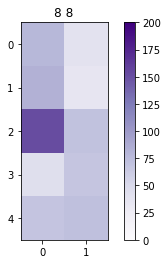

AVG plot
[[ 78.64  38.69]
 [ 83.4   34.7 ]
 [152.93  70.52]
 [ 43.6   67.51]
 [ 68.34  72.32]]


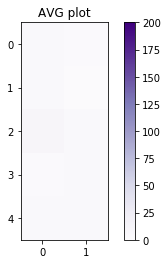

IndexError: too many indices for array

In [10]:
# fig = plt.figure(figsize=(9*4, 7*5)) #

# import matplotlib.pyplot as plt
# plt.imshow(np.arange(16).reshape((4, 4)), cmap='Purples', interpolation='none', extent=[2,32,2,8])
# plt.colorbar()
# # plt.xscale('log')
# # plt.yscale('log')
# # ticks = [1, 2]
# # plt.xticks(ticks)
# plt.title("ABC")
# plt.show()

print('# Algorithm, state_space_size, action_space_size, delay, sequence_length, reward_density,'
               'terminal_state_density ')
print(algorithms, state_space_sizes, action_space_sizes, delays, sequence_lengths, reward_densities,
      terminal_state_densities)

AVG = np.squeeze(metrics_reshaped[:, 0, 0, :, :, :, :, 1].copy())
AVG[:] = 0

for i in range(len(state_space_sizes)):
    for j in range(len(action_space_sizes)):
        to_plot_ = np.squeeze(metrics_reshaped[:, i, j, :, :, :, :, 1])
        print(np.squeeze(metrics_reshaped[:, i, j, :, :, :, :, 0]), metrics_reshaped[:, :, :, :, :, :, :, :].shape)
        AVG += to_plot_
        print(to_plot_)
        import matplotlib.pyplot as plt
        plt.imshow(to_plot_, cmap='Purples', interpolation='none', vmin=0, vmax=200)#, extent=[0, 16, 8, 14])
        plt.colorbar()
#         plt.xscale('log')
#         plt.yscale('log')
        plt.title(str(state_space_sizes[i]) + ' ' + str(action_space_sizes[j]))
        plt.show()

print("AVG plot")
print(AVG)
import matplotlib.pyplot as plt
plt.imshow(AVG/16, cmap='Purples', interpolation='none', vmin=0, vmax=200)#, extent=[0, 16, 8, 14])
plt.colorbar()
#         plt.xscale('log')
#         plt.yscale('log')
plt.title('AVG plot')
plt.show()



AVG = np.squeeze(metrics_reshaped[:, :, :, 0, 0, :, :, 1].copy())
AVG[:] = 0

for i in range(len(delays)):
    for j in range(len(sequence_lengths)):
        to_plot_ = np.squeeze(metrics_reshaped[:, :, :, i, j, :, :, 1])
        AVG += to_plot_
        print(to_plot_)
        import matplotlib.pyplot as plt
        plt.imshow(to_plot_, cmap='Purples', interpolation='none', vmin=0, vmax=200)#, extent=[0, 16, 8, 14])
        plt.colorbar()
#         plt.xscale('log')
#         plt.yscale('log')
        plt.title(str(delays[i]) + ' ' + str(sequence_lengths[j]))
        plt.show()



print("AVG plot")
print(AVG)
import matplotlib.pyplot as plt
plt.imshow(AVG/16, cmap='Purples', interpolation='none', vmin=0, vmax=200)#, extent=[0, 16, 8, 14])
plt.colorbar()
#         plt.xscale('log')
#         plt.yscale('log')
plt.title('AVG plot')
plt.show()



In [ ]:
#####INCOMPLETE
# 2-D heatmaps
#
# 
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

# alg_name = 'DQN'

# measure = 'time'
# measure = 'memory'
# dataset_index = np.where(dataset_names==dataset_name)[0][0]
# print(type(dataset_index), dataset_index.dtype)
# column_no = 19 # Refer to comments above to decide the benchmark column or measure to choose

fig = plt.figure(figsize=(9*4, 7*5)) #


# column_names = ['train', '\"val\"','test_1','test_4']
# column_nos = np.arange(4, 22, 5) #set starting value to 4 for performances, 5 for scoring times
# print(column_nos.shape, dataset_names.shape)
for i in range(len(state_space_sizes)):
    for j in range(len(action_space_sizes)):
        for k in range(len(delays)):
            for l in range(len(sequence_lengths)):
                print("Plotting for |S|, |A|, d, n: ", state_space_sizes[i], action_space_sizes[j], delays[k]
                     sequence_lengths[l])
                values_[0, i, j]

        

plt.savefig('/home/rajanr/Downloads/temp.png')


In [83]:
num_ = 5
len_ = 3
nums_ = list(range(num_ + 1 - len_, num_ + 1))
print(nums_, np.random.randint(np.prod(nums_)))
unique_seqs_ = []
for i in range(np.prod(nums_)):
    curr_num = i
    seq_ = []
    curr_rem_nums_ = list(range(num_))
    for j in nums_[::-1]:
        rem_ = curr_num % j
        seq_.append(curr_rem_nums_[rem_])
        del curr_rem_nums_[rem_]
#         print("curr_rem_nums_", curr_rem_nums_)
        curr_num = curr_num // j
#         print(rem_, curr_num, j, seq_)
    print("T/F:", seq_ in unique_seqs_)
    unique_seqs_.append(seq_)
#print(len(set(unique_seqs_))) #error

print(np.unique(unique_seqs_))
#         print(i % 3, i % 4, i % 5, i)




[3, 4, 5] 47
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
T/F: False
[0 1 2 3 4]


In [48]:
np.random.seed(0)
np.random.choice(5)

4

In [ ]:
#temp

new_file = "/home/rajanr/temp.txt"
fout = open(new_file, 'a') #hardcoded
for line in open(stats_file):
    if line.startswith("#"):
        
        vals = line.split(',')[-1]
#         print(vals)
    else:
        vals2 = line
#         print(line)
    
        print(vals[1:-1] + ' ' + vals2)
        fout.write(vals[1:-1] + ' ' + vals2)
# # fout.flush()
fout.close()


In [82]:
from os import getcwd as pwd
from glob import glob #ls = sorted(glob(filename))
from ray.tune.analysis import ExperimentAnalysis

for filename in sorted(glob('/mhome/rajanr/ray_results/DQN/*.json')):
    print(filename)
    try:
        print(ExperimentAnalysis(filename, trials=None))
    except Exception as e:
        print("EXCEPTION", filename, e)

/mhome/rajanr/ray_results/DQN/experiment_state-2019-05-21_21-09-59.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-05-23_17-07-12.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-05-24_12-57-51.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-05-28_11-57-24.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_15-20-54.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_15-23-58.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_15-23-59.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_15-24-00.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_15-24-14.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_15-24-16.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_15-24-17.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_15-24-18.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_15-24-19.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_15-24-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-14-58.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-15-08.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-15-13.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-15-15.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-15-17.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-15-20.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-15-25.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-15-29.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-15-47.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-16-55.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-17-04.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-17-06.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-17-10.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-17-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-46-07.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-46-20.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-46-25.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-46-26.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-46-43.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-46-54.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-47-17.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-48-01.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-48-16.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-48-19.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-48-20.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-48-37.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-48-46.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_16-49-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-21-04.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-21-11.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-21-21.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-21-23.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-21-32.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-22-26.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-22-28.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-22-44.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-23-08.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-23-14.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-23-21.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-23-31.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-23-46.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-24-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-52-58.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-53-03.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-53-12.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-53-58.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-54-09.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-54-25.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-54-39.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-54-45.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-54-50.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-54-57.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-55-01.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-55-43.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-55-57.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_17-56-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-24-42.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-24-55.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-25-02.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-25-23.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-26-01.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-26-02.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-26-05.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-26-24.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-26-25.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-26-47.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-26-52.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-26-55.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-27-14.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-27-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-54-51.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-55-22.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-55-23.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-55-34.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-55-42.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-55-54.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-56-02.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-56-12.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-56-27.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-56-34.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-57-16.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-57-30.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-57-36.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_18-57-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_19-28-41.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_19-28-42.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_19-28-47.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_19-29-16.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_19-30-26.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_19-30-27.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_19-30-40.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_19-30-44.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_19-30-49.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_19-30-52.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_19-30-54.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_19-30-56.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_19-31-31.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_19-32-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-09-04.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-09-34.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-09-40.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-10-03.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-10-07.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-10-17.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-10-22.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-10-59.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-11-02.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-11-06.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-11-47.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-11-50.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-12-14.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-12-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-52-07.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-52-39.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-52-58.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-53-08.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-53-22.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-54-06.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-54-19.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-54-50.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-54-55.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-54-56.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-55-35.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-56-49.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-56-56.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_20-56-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_21-43-16.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_21-43-34.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_21-43-38.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_21-43-43.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_21-44-09.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_21-44-37.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_21-44-44.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_21-45-33.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_21-45-39.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_21-45-50.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_21-46-06.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_21-46-47.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_21-46-54.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_21-47-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_22-24-09.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_22-24-12.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_22-24-18.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_22-24-58.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_22-26-07.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_22-26-11.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_22-26-16.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_22-26-22.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_22-26-23.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_22-26-58.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_22-27-24.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_22-28-14.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_22-28-27.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_22-28-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-12-55.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-13-19.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-13-48.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-14-00.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-14-14.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-14-21.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-14-28.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-14-30.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-15-04.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-15-30.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-16-04.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-16-17.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-16-36.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-16-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-53-58.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-54-28.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-54-29.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-54-38.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-54-47.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-55-44.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-56-10.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-56-33.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-56-37.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-56-39.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-56-58.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-57-13.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-57-52.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-22_23-58-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_00-31-12.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_00-31-16.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_00-31-50.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_00-31-55.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_00-32-23.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_00-33-21.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_00-33-25.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_00-33-55.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_00-33-59.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_00-34-34.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_00-34-35.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_00-35-32.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_00-35-51.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_00-36-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-08-32.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-09-31.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-09-54.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-10-00.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-10-40.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-11-11.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-12-00.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-12-04.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-12-06.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-12-13.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-12-14.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-12-45.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-12-47.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-13-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-45-15.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-45-50.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-46-24.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-46-52.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-46-55.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-47-14.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-47-18.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-47-38.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-48-12.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-48-30.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-49-19.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-49-30.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-49-47.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_01-50-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_02-25-28.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_02-25-44.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_02-25-48.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_02-26-22.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_02-26-50.json
EXCEPTION /mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_02-26-50.json Extra data: line 122 column 1 (char 6314)
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_02-27-00.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_02-27-06.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_02-27-19.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_02-27-43.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_02-28-04.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_02-28-16.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_02-28-27.json
/mhome/rajan

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_03-10-23.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_03-10-38.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_03-10-51.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_03-11-57.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_03-12-03.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_03-12-06.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_03-12-24.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_03-12-28.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_03-12-50.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_03-14-12.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_03-14-23.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_03-14-54.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_03-15-03.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_03-15-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_03-57-11.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_03-58-34.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_03-59-03.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_03-59-27.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_03-59-38.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-00-01.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-00-48.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-01-37.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-02-04.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-02-09.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-02-53.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-04-07.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-04-17.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-04-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-51-49.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-52-09.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-52-35.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-52-49.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-53-25.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-53-54.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-54-01.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-55-05.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-55-35.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-56-02.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-56-12.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-57-09.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-57-48.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_04-58-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_05-57-23.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_05-57-46.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_05-57-55.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_05-58-22.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_05-58-26.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_05-58-34.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_06-00-00.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_06-00-15.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_06-00-31.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_06-00-34.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_06-00-40.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_06-00-47.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_06-02-07.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_06-02-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_07-14-52.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_07-15-51.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_07-16-34.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_07-17-11.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_07-18-39.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_07-18-58.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_07-19-37.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_07-19-52.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_07-19-57.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_07-20-50.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_07-21-10.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_07-21-42.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_07-21-53.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_07-23-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_09-06-29.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_09-07-26.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_09-07-31.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_09-07-58.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_09-09-09.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_09-09-26.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_09-09-32.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_09-10-09.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_09-10-13.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_09-10-31.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_09-11-39.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_09-12-31.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_09-12-42.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_09-14-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_10-56-44.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_10-56-49.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_10-57-59.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_10-59-18.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_11-00-23.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_11-00-25.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_11-01-32.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_11-02-16.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_11-03-46.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_11-03-58.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_11-04-33.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_11-06-02.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_11-06-26.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_11-06-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_12-52-06.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_12-52-21.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_12-52-34.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_12-52-37.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_12-54-16.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_12-54-29.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_12-55-00.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_12-56-26.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_12-56-38.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_12-57-01.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_12-58-42.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_12-58-49.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_12-59-04.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_13-01-

/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_14-35-59.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_14-36-16.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_14-37-51.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_14-38-16.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_14-40-09.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_14-41-13.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_14-41-16.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_14-43-17.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_14-43-26.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_14-45-34.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_14-47-49.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_14-47-52.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_14-48-32.json
/mhome/rajanr/ray_results/DQN/experiment_state-2019-08-23_14-49-